# Inverse-Model
Implementation steps
- [x] implement hessian-vector product
    - gradient convergence according to Taylor-ish test.
    - hessian approximation is close to finite-differences.
- [x] implement projected newton solver
    - still not tested with optimal values along boundary or outside bounds.
- [x] ensure correctness with measurement times not conforming to grid
    - measurements according to piecewise constant. Linear interpolation would require more work.
- [x] verify functioning model with linear interpolation of boundary concentrations
    - Does at least converge to a solution in the 2D case.
- [.] extend to full 3d brain with proper data
    - struggle with getting convergence right. should return after some performance optimization
- [ ] performance optimization by caching
- [ ] run full model for all subjects
- [ ] enable linear interpolation measurements

In [1]:
import numpy as np
import dolfin as df
import tqdm
import pint
from dolfin import inner, grad, dot

from glymphopt.datageneration import BoundaryConcentration
from glymphopt.finite_differences import gradient_finite_differences, hessian_finite_differences
from glymphopt.interpolation import LinearDataInterpolator
from glymphopt.io import read_mesh, read_function_data
from glymphopt.measure import measure
from glymphopt.minimize import projected_newton_solver
from glymphopt.operators import (
    mass_matrix, boundary_mass_matrix, stiffness_matrix, matrix_operator, bilinear_operator, matmul, zero_vector
)
from glymphopt.parameters import parameters_2d_default
from glymphopt.timestepper import TimeStepper

[garrus:05813] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.garrus.1000/jf.0/1377107968/shared_mem_cuda_pool.garrus could be created.
[garrus:05813] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [1]:
import numpy as np
import dolfin as df
import tqdm
import pint
from dolfin import inner, grad, dot

from glymphopt.datageneration import BoundaryConcentration
from glymphopt.finite_differences import gradient_finite_differences, hessian_finite_differences
from glymphopt.interpolation import LinearDataInterpolator
from glymphopt.io import read_mesh, read_function_data
from glymphopt.measure import measure
from glymphopt.minimize import projected_newton_solver
from glymphopt.operators import (
    mass_matrix, boundary_mass_matrix, stiffness_matrix, matrix_operator, bilinear_operator, matmul, zero_vector
)
from glymphopt.parameters import parameters_2d_default
from glymphopt.timestepper import TimeStepper

[garrus:05813] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.garrus.1000/jf.0/1377107968/shared_mem_cuda_pool.garrus could be created.
[garrus:05813] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [109]:
class CacheObject:
    def __init__(self):
        self.lastx = {}
        self.val = None

def cache_fetch(cache, func, cache_kwargs, **funkwargs):
    is_old_kwargs = all([
            key in cache.lastx and np.array_equal(val, cache.lastx[key])
            for key, val in cache_kwargs.items()
    ])
    if is_old_kwargs:
        val = cache.val
    else:
        fval = func(**funkwargs)
        cache.val = fval
        for key, val in cache_kwargs.items():
            cache.lastx[key] = val
    return cache.val

In [94]:
def vector2coeff(x: np.ndarray, *args):
    return parameters_2d_default() | {key: xi for key, xi in zip(args, x)}
    T = pint.Quantity("1s")
    X = pint.Quantity("1mm")
    timescale = float(pint.Quantity("1s") / T)
    params = singlecomp_parameters(get_dimless_parameters(T, X))
    coefficients = remove_units(params)
    return remove_units(params) | {key: xi for key, xi in zip(args, x)}


def coeff2vector(coefficients: dict[str, float], *args):
    return np.array([coefficients[key] for key in args])

class Model:
    def __init__(self, V, D=None, g=None):
        D = D or df.Identity(V.mesh().topology().dim())
        
        domain = V.mesh()
        dx = df.Measure("dx", domain)
        ds = df.Measure("ds", domain)
        
        u, v = df.TrialFunction(V), df.TestFunction(V)
        self.M = df.assemble(inner(u, v) * dx)
        self.DK = df.assemble(inner(D * grad(u), grad(v)) * dx)
        self.S = df.assemble(inner(u, v) * ds)
        self.g = g or BoundaryConcentration(V)


def gradient_sensitivities(F, x, **kwargs):
    return np.array([F(x, ei, **kwargs) for ei in np.eye(len(x))])

def measure_interval(n: int, td: np.ndarray, timestepper: TimeStepper):
    bins = np.digitize(td, timestepper.vector(), right=True)
    return list(np.where(n == bins)[0])

class InverseProblem:
    def __init__(self, data_path, dt=0.1, g=None, D=None, progress=True):
        self.silent = not progress
        domain = read_mesh(data_path)
        self.td, self.Yd = read_function_data(data_path, domain, "concentration")
        t_start = self.td[0]
        N = int(np.ceil(np.round((self.td[-1] - t_start) / dt, 12)))
        t_end = N * dt
        self.timestepper = TimeStepper(dt, (t_start, t_end))
        self.V = self.Yd[0].function_space()
        
        g = g or BoundaryConcentration(self.V)
        self.model = Model(self.V, g=g, D=D)
        self.cache = {
            "state": CacheObject(),
            "adjoint": CacheObject(),
            "g": CacheObject(),
            "sensitivity": CacheObject(),
            "operator": CacheObject(),
        }
        
    def F(self, x):
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        _M_ = bilinear_operator(self.model.M)
        J = 0.5 * sum([
            _M_(Ym_i.vector() - Yd_i.vector(), Ym_i.vector() - Yd_i.vector()) 
            for Ym_i, Yd_i in zip(Ym, self.Yd)
        ])
        return J
    
    def boundary_vectors(self):
        model = self.model
        timestepper = self.timestepper
        return [matmul(model.S, model.g(t)) for t in timestepper.vector()]

    
    def gradF(self, x):
        dt = self.timestepper.dt
        model = self.model
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        
        P = cache_fetch(self.cache["adjoint"], self.adjoint, {"x": x}, x=x, Ym=Ym)
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"_": ""})
                                
        _M_ = bilinear_operator(model.M)
        _DK_ = bilinear_operator(model.DK)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(p.vector(), y.vector()),
                _M_(p.vector(), y.vector()),
                _S_(p.vector(), y.vector()) - p.vector().inner(g),
            ])
            for y, p, g in zip(Y[1:], P[:-1], G[1:])
        )

    def dF(self, x, dx):
        timestepper = self.timestepper
        coefficients = vector2coeff(x)
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        dY = cache_fetch(self.cache["sensitivity"], self.sensitivity, {"x": x, "dx": dx}, x=x, dx=dx, Y=Y)
        Ym = measure(timestepper, Y, self.td)
        dYm = measure(timestepper, dY, self.td)
        _M_ = bilinear_operator(self.model.M)
        return sum([_M_(ym.vector() - yd.vector(), dy.vector()) for ym, yd, dy in zip(Ym, self.Yd, dYm)])
    
    def hess(self, x):
        return np.array([
            self.hessp(x, ei) for ei in np.eye(len(x))
        ])
    
    def hessp(self, x, dx):
        dt = self.timestepper.dt
        Y = cache_fetch(self.cache["state"], self.forward, {"x": x}, x=x)
        Ym = measure(self.timestepper, Y, self.td)
        dY = cache_fetch(self.cache["sensitivity"], self.sensitivity, {"x": x, "dx": dx}, x=x, dx=dx, Y=Y)
        dYm = measure(self.timestepper, dY, self.td)
        
        P = cache_fetch(self.cache["adjoint"], self.adjoint, {"x": x}, x=x, Ym=Ym)
        dP = self.second_order_adjoint(x, dx, dYm, P)
        
        model = self.model
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"_": ""})
        _DK_ = bilinear_operator(model.DK)
        _M_ = bilinear_operator(model.M)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(dp.vector(), y.vector()) + _DK_(p.vector(), dy.vector()),
                _M_(dp.vector(), y.vector()) + _M_(p.vector(), dy.vector()),
                _S_(dp.vector(), y.vector()) - dp.vector().inner(g) + _S_(p.vector(), dy.vector()),
            ])
            for y, dy, p, dp, g in zip(Y[1:], dY[1:], P[:-1], dP[:-1], G[1:])
        )

    def forward(self, x):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        Y = [
            df.Function(self.V, name="state") 
            for _ in range(len(timepoints))
        ]
        Y[0].assign(self.Yd[0])
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        Mdot = matrix_operator(M)
        G = cache_fetch(self.cache["g"], self.boundary_vectors, {"_": ""})
        N = self.timestepper.num_intervals()
        for n in tqdm.tqdm(range(N), total=N, disable=self.silent):
            solver.solve(Y[n+1].vector(), Mdot(Y[n].vector()) + dt * k * G[n+1])
        return Y
    
    def adjoint(self, x, Ym) -> list[df.Function]:
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        P = [
            df.Function(self.V, name="adjoint") 
            for _ in range(len(timepoints))
        ]
        Mdot = matrix_operator(M)
        num_intervals = timestepper.num_intervals()
        for n in range(num_intervals, 0, -1):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, (Ym[j].vector() - Yd[j].vector())) for j in nj))

            solver.solve(
                P[n-1].vector(),
                Mdot(P[n].vector()) - jump,
            )
        return P
    
    def sensitivity(self, x, dx, Y) -> list[df.Function]:
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        dY = [df.Function(self.V, name="sensitivity") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)
        
        dL = dD * model.DK + dr * model.M + dk * model.S
        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        Sdot = matrix_operator(model.S)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        for n, t in enumerate(timepoints[1:], start=0):
            solver.solve(
                dY[n+1].vector(),
                Mdot(dY[n].vector()) - dt * dLdot(Y[n+1].vector()) + dt * dk * G[n+1]
            )
        return dY
    
    def second_order_adjoint(self, x, dx, dYm, P):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        dP = [df.Function(self.V, name="second-order-adjoint") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        dL = dD * model.DK + dr * model.M + dk * model.S
        solver = cache_fetch(self.cache["operator"], df.LUSolver, {"x": x}, A=M + dt * L)

        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        num_intervals = timestepper.num_intervals()
        for n in range(num_intervals, 0, -1):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, dYm[j].vector()) for j in nj))
            solver.solve(
                dP[n - 1].vector(),
                Mdot(dP[n].vector()) - dt * dLdot(P[n-1].vector()) - jump,
            )
        return dP

In [101]:
data_path = "../resources/concentrations.hdf"
# data_path = "/home/jorgen/gonzo/mri_processed_data/sub-01/modeling/resolution32/data.hdf"
domain = read_mesh(data_path)
td, Yd = read_function_data(data_path, domain, "concentration")
td, Y_bdry = read_function_data(data_path, domain, "boundary_concentration")
g = LinearDataInterpolator(td, Y_bdry)
# g = None
# D = 1.3e-4 * df.Identity(domain.topology().dim())
D = df.Identity(domain.topology().dim())

# T = pint.Quantity("1s")
# X = pint.Quantity("1mm")
# timescale = float(pint.Quantity("1s") / T)
# params = singlecomp_parameters(get_dimless_parameters(T, X))
# coefficients = remove_units(params)
coefficients = parameters_2d_default()


x0 = coeff2vector(coefficients, "a", "r", "k")
x1 = 0.9 * x0


# problem = InverseProblem(data_path, dt=3600, g=g, D=D)
problem = InverseProblem(data_path, dt=0.1, g=g, D=D, progress=False)
# problem.F(x0)

# Convergence test for gradient

Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
h = 0.1, errornorm = 3.866148948805842, rel=
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
h = 0.05, errornorm = 0.9612062290099521, rel=4.022184659360767
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
h = 0.025, errornorm = 0.2399705634239533, rel=4.005517240511703
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
h = 0.0125, errornorm = 0.05997198559663154, rel=4.001377660529415
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
h = 0.00625, errornorm = 0.014991716224916015, rel=4.000341568429569
Fetching from cache
Fetching from cache
Fetching f

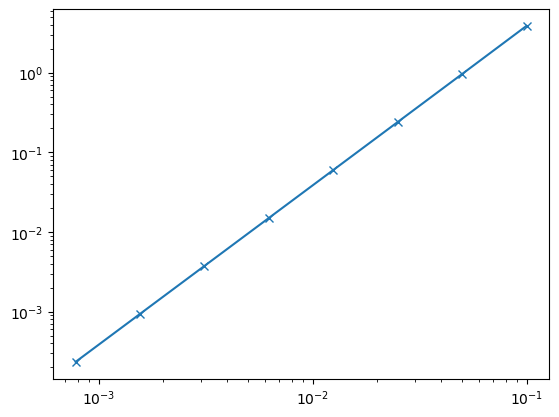

In [102]:
import matplotlib.pyplot as plt
gradF = problem.gradF(x1)

hs = [0.5**i * 1e-1 for i in range(8)]
errors = np.nan * np.zeros_like(hs)
for i, h in enumerate(hs):
    dF_findiff = gradient_finite_differences(problem.F, x1, h=h)
    errors[i] = np.linalg.norm(gradF - dF_findiff)
    if i > 0:
        print(f"h = {h}, errornorm = {errors[i]}, rel={errors[i-1]/errors[i]}")
    else:
        print(f"h = {h}, errornorm = {errors[i]}, rel=")

plt.loglog(hs, errors, "x-")
plt.show()

# Hessians

In [103]:
H = problem.hess(x1)
H

Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache


array([[ 1.25457674e+01, -2.61347377e+03,  8.14490295e+00],
       [-2.61347377e+03,  2.56111661e+06, -1.15940138e+04],
       [ 8.14490295e+00, -1.15940138e+04,  6.62976604e+02]])

In [104]:
H_fd = hessian_finite_differences(problem.F, x1, h=1e-5)
H_fd

Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache


array([[ 1.25373845e+01, -2.61347324e+03,  8.14445400e+00],
       [-2.61347324e+03,  2.56111695e+06, -1.15940153e+04],
       [ 8.14445400e+00, -1.15940153e+04,  6.62974742e+02]])

In [105]:
(H_fd - H) / H

array([[-6.68188135e-04, -2.00774528e-07, -5.51207637e-05],
       [-2.00774528e-07,  1.32963841e-07,  1.26975588e-07],
       [-5.51207637e-05,  1.26975589e-07, -2.80936261e-06]])

In [106]:
x1

array([9.090e+00, 9.000e-04, 1.179e+00])

In [107]:
x0

array([1.01e+01, 1.00e-03, 1.31e+00])

In [108]:
import time as pytime
import scipy.optimize
bounds = scipy.optimize.Bounds([1e-1, 0, 0], [np.inf, np.inf, np.inf])
x0 = [1.0, 2e-5, 1e-3] # 3D 
x0 = [8.0, 1e-4, 2]  # 2D test example
sol_x = projected_newton_solver(
    problem.F,
    problem.gradF,
    problem.hessp,
    bounds=bounds,
    x0=x0,
    inner_tol=1e-8,
    verbose=True,
)
toc = pytime.time()
sol_x

Iter     Objective    Proj. Grad Norm
----------------------------------------
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
   0  1.016640e+02       8.591813e+03
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
0	[9.57592732 0.         2.13022401]	101.66398802043621	[ -39.91773057 8591.63352206  -38.63550648]	0.8130124156294931
Fetching from cache
Fetching from cache
Fetching from cache
Fetching from cache
   1  5.744166e+01       1.552166e+01
Fetching from cache
Fetching from cache
Fetchi

  message: Convergence: Projected gradient norm below tolerance.
  success: True
      fun: 45.97874184132122
        x: [ 1.172e+01  1.360e-03  2.017e+00]
      nit: 6
     nfev: 7
     njev: 7
     nhev: 28
      jac: [-1.898e-13  1.652e-10 -1.271e-13]
 walltime: 29.17109966278076